In [70]:
# Cell 1: Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch
import os
import time
from abc import ABC, abstractmethod
from math import atan2, cos, sin, sqrt, pi
import logging  # For better debugging
from typing import Optional, Tuple, List  # For type hints

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

c:\nabil\Nepali_Ocr\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\nabil\Nepali_Ocr\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Enhanced image is sharper, proceeding with it


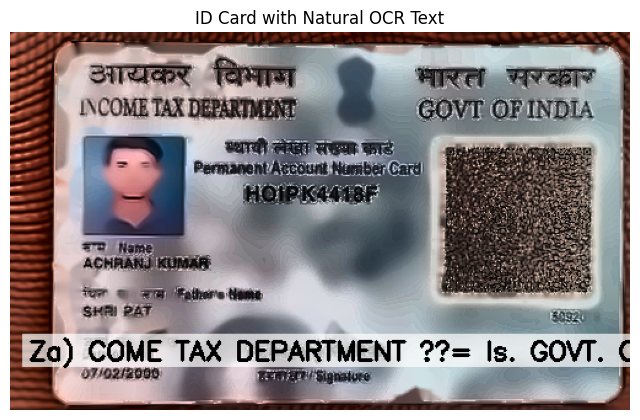

In [1]:
import os
import cv2
import numpy as np
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import pytesseract
import matplotlib.pyplot as plt
from pathlib import Path

# Set Tesseract path (update this based on your installation)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Windows example

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define input directory
input_folder = Path("input")
input_folder.mkdir(exist_ok=True)

# Function to measure image sharpness
def measure_sharpness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var()

# Function to preprocess image for Faster R-CNN
def preprocess_image(image_path):
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = F.to_tensor(img_rgb).unsqueeze(0)  # Add batch dimension
    return img, img_rgb, img_tensor

def enhance_image(image):
    # Noise reduction with non-local means denoising
    denoised = cv2.fastNlMeansDenoisingColored(image, h=10, hColor=10, templateWindowSize=7, searchWindowSize=21)
    
    # Deblur using Gaussian blur and sharpening
    blurred = cv2.GaussianBlur(denoised, (5, 5), 0)
    sharpened = cv2.addWeighted(denoised, 1.5, blurred, -0.5, 0)
    
    # Contrast adjustment using CLAHE
    lab = cv2.cvtColor(sharpened, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4, 4))
    l = clahe.apply(l)
    lab = cv2.merge((l, a, b))
    enhanced = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    # Glare removal
    gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY)
    enhanced = cv2.inpaint(enhanced, mask, 3, cv2.INPAINT_TELEA)
    return enhanced

# Function to correct skew and align the ID card
def correct_skew(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi / 180, 200)
    angle = 0
    if lines is not None:
        for rho, theta in lines[0]:
            angle = (theta * 180 / np.pi) - 90
            break
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

# Function to detect ROIs with Faster R-CNN
def detect_rois(model, img_tensor, threshold=0.5):
    with torch.no_grad():
        predictions = model(img_tensor)[0]
    boxes = predictions['boxes'].cpu().numpy()
    scores = predictions['scores'].cpu().numpy()
    labels = predictions['labels'].cpu().numpy()
    mask = scores > threshold
    return boxes[mask], scores[mask], labels[mask]

# Function to extract text from ROIs using OCR with preprocessing
def extract_text_from_roi(image, box):
    x1, y1, x2, y2 = map(int, box)
    roi = image[y1:y2, x1:x2]
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    text = pytesseract.image_to_string(thresh, config='--psm 6')
    return text.strip()

# Function to crop the ID card from the image
def crop_id_card(image, boxes):
    if len(boxes) == 0:
        return image
    largest_box = max(boxes, key=lambda b: (b[2] - b[0]) * (b[3] - b[1]))
    x1, y1, x2, y2 = map(int, largest_box)
    cropped = image[y1:y2, x1:x2]
    return cropped

# Function to find a suitable text placement region
def find_text_placement_region(image):
    h, w = image.shape[:2]
    return h - int(h * 0.2), h, 0, w

# Main processing function with quality comparison
def process_and_display_id_card(image_path):
    # Load and preprocess image
    original_img, img_rgb, img_tensor = preprocess_image(image_path)

    # Enhance and align the image
    enhanced_img = enhance_image(original_img)
    original_sharpness = measure_sharpness(original_img)
    enhanced_sharpness = measure_sharpness(enhanced_img)
    
    # Choose the better image based on sharpness
    if original_sharpness > enhanced_sharpness:
        print("Original image is sharper, using it instead of enhanced version")
        base_img = original_img
    else:
        print("Enhanced image is sharper, proceeding with it")
        base_img = enhanced_img
    
    aligned_img = correct_skew(base_img)

    # Detect ROIs
    _, _, enhanced_tensor = preprocess_image(image_path)
    boxes, scores, labels = detect_rois(model, enhanced_tensor)

    # Extract text from ROIs
    ocr_results = []
    for i, box in enumerate(boxes[:5]):  # Limit to top 5 ROIs
        text = extract_text_from_roi(aligned_img, box)
        confidence = scores[i] * 100
        if text:
            ocr_results.append(f"{text} ({confidence:.1f}%)")

    # Crop the ID card
    cropped_id = crop_id_card(aligned_img, boxes)
    
    # Only re-enhance if we used the original image
    if original_sharpness > enhanced_sharpness:
        final_img = cropped_id
    else:
        final_img = enhance_image(cropped_id)

    # Find placement region for text
    y_start, y_end, x_start, x_end = find_text_placement_region(final_img)
    output_img = final_img.copy()

    # Overlay OCR text
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    font_thickness = 2
    text_color = (0, 0, 0)
    bg_color = (255, 255, 255, 50)

    y_offset = y_start + 20
    for result in ocr_results:
        (text_w, text_h), baseline = cv2.getTextSize(result, font, font_scale, font_thickness)
        
        bg_x, bg_y = 10, y_offset - text_h - 5
        bg_w, bg_h = text_w + 10, text_h + 10
        overlay = output_img.copy()
        cv2.rectangle(overlay, (bg_x, bg_y), (bg_x + bg_w, bg_y + bg_h), bg_color[:3], -1)
        cv2.addWeighted(overlay, 0.7, output_img, 0.3, 0, output_img)
        
        cv2.putText(output_img, result, (bg_x + 5, y_offset), font, font_scale, text_color, font_thickness)
        y_offset += text_h + 15

        if y_offset + text_h > output_img.shape[0]:
            break

    # Display the result
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("ID Card with Natural OCR Text")
    plt.show()

# Process the first image in the input folder
image_files = list(input_folder.glob("*.jpg"))
if image_files:
    process_and_display_id_card(image_files[0])
else:
    print("No images found in the 'input' folder. Please add an ID card image (e.g., 'id_card.jpg').")

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  # For plotting histograms

# 1. Load original image in color
color_image = cv2.imread("input/sample2.jpg")
if color_image is None:
    print("Oops! Image not found! Please check the file path.")
    exit()
print("🔹 Step 1: Original Color Image")
cv2.imshow("Original Color Image", color_image)

# 2. Convert to grayscale
gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
print("🔹 Step 2: Grayscale Image")
cv2.imshow("Grayscale Image", gray)

# 3. Smooth the image and detect edges using Canny
gray = cv2.GaussianBlur(gray, (47, 47), 0)
edges = cv2.Canny(gray, 200, 200)
print("🔹 Step 3: Canny Edge Detection")
cv2.imshow("Canny Edges", edges)
print(f"Grayscale Shape: {gray.shape}")

# 4. Convert to binary using Otsu's thresholding
_, binary = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("🔹 Step 4: Binary Image (Otsu Thresholding)")
cv2.imshow("Binary Image", binary)

# 5. Find external contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 6. Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)

# 7. Get rotated bounding rectangle around the largest contour
rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = np.int_(box)

# Draw the box on original image
image_with_box = color_image.copy()
cv2.drawContours(image_with_box, [box], 0, (0, 0, 255), 2)
print("🔹 Step 5: Rotated Red Bounding Box")
cv2.imshow("Image with Bounding Box", image_with_box)

# 8. Crop the detected object (simple way)
x, y, w, h = cv2.boundingRect(largest_contour)
cropped_color = color_image[y:y+h, x:x+w]
print("🔹 Step 6: Cropped Color Region (Simple Bounding Box)")
cv2.imshow("Cropped Simple", cropped_color)

# 9. Crop with rotated rectangle (precise way)
mask = np.zeros_like(gray)
cv2.drawContours(mask, [box], 0, 255, -1)
cropped_rotated = color_image.copy()
cropped_rotated = cv2.bitwise_and(cropped_rotated, cropped_rotated, mask=mask)
x_rot, y_rot, w_rot, h_rot = cv2.boundingRect(mask)
cropped_rotated = cropped_rotated[y_rot:y_rot+h_rot, x_rot:x_rot+w_rot]
print("🔹 Step 7: Cropped Color Region (Rotated Bounding Box)")
cv2.imshow("Cropped Rotated", cropped_rotated)

# 10. Calculate Color Histogram for Cropped Region (Rotated Crop)
blue, green, red = cv2.split(cropped_rotated)
hist_blue = cv2.calcHist([blue], [0], None, [256], [0, 256])
hist_green = cv2.calcHist([green], [0], None, [256], [0, 256])
hist_red = cv2.calcHist([red], [0], None, [256], [0, 256])

# Plot the histograms
plt.figure(figsize=(10, 4))
plt.title("Color Histogram of Cropped Newt")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Number of Pixels")
plt.plot(hist_blue, color='blue', label='Blue')
plt.plot(hist_green, color='green', label='Green')
plt.plot(hist_red, color='red', label='Red')
plt.legend()
plt.show()
print("🔹 Step 8: Color Histogram of Rotated Crop")

# 11. Enhance the Image to Make It More Readable
hsv_image = cv2.cvtColor(cropped_rotated, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv_image)
v = cv2.add(v, 50)  # Brighten by adding 50 (cap at 255)
s = cv2.add(s, 50)  # Boost saturation for more vivid colors
v = np.clip(v, 0, 255)  # Ensure values stay between 0-255
s = np.clip(s, 0, 255)

# Merge back and convert to BGR
enhanced_hsv = cv2.merge([h, s, v])
enhanced_image = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)
print("🔹 Step 9: Enhanced Cropped Image (Brighter and More Colorful)")
cv2.imshow("Enhanced Image", enhanced_image)

# Keep windows open until a key is pressed
cv2.waitKey(0)
cv2.destroyAllWindows()

Oops! Image not found! Please check the file path.
🔹 Step 1: Original Color Image


error: OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:973: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


: 